In [21]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.layers import Reshape
from keras.models import Model
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import load_img, img_to_array
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras.datasets import mnist
import numpy as np
from PIL import Image
import argparse
import math
from keras.applications import VGG16, vgg16
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
def gram_matrix(x):
    assert K.ndim(x) == 3
    features = K.batch_flatten(K.permute_dimensions(x, (0, 1, 2)))
    gram = K.dot(features, K.transpose(features))
    return gram

# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image

def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    sLoss = K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
    return sLoss

# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
    b = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    return K.sum(K.pow(a + b, 1.25))

In [61]:
total_variation_weight = 1.0
style_weight = 1000.0
content_weight = 0.025 

img_nrows = 224
img_ncols = 224

In [62]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img) * 1.0
    img = np.expand_dims(img, axis=0)
#     img = vgg16.preprocess_input(img)
    return img

In [63]:
def get_loss(y_true, y_pred):
    loss = style_loss(y_true[0, :, :, :], y_pred[0, :, :, :])
    return style_weight*loss/5.0

def c_loss(y_true, y_pred):
    loss = content_loss(y_true[0, :, :, :], y_pred[0, :, :, :])
    return content_weight*loss

def var_loss(y_true, y_pred):
    loss = total_variation_weight*total_variation_loss(y_pred)

In [72]:
# Combine generative layer with VGG layer
inputs = Input(shape=( 224*224*3, ))
    
# Layer 1
x1 = Dense(5, activation = 'tanh', init = 'glorot_uniform')(inputs)

# Layer 2
x = Dense(64*56*56, activation = 'tanh', init = 'glorot_uniform')(x1)
x = BatchNormalization()(x)
x = Reshape((64, 56, 56))(x)

# # Layer 3
x = UpSampling2D(size = (2, 2))(x) #shape is (16, 14, 14)
x = Convolution2D(16, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# # Layer 4
# x = UpSampling2D(size = (2, 2))(x) #shape is (16, 28, 28)
# x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'relu')(x)

# # Layer 5
# x = UpSampling2D(size = (4, 4))(x) #shape is (16, 112, 112)
# x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'relu')(x)

# Layer 6
x = UpSampling2D(size = (2, 2))(x) # 28, 28 -> 224, 224
out = Convolution2D(3, 5, 5, border_mode = 'same', activation = 'sigmoid')(x)

#  output shape is (None, 3, 224, 224)
generative_model = Model(input = inputs, output = out)

## VGG definition
vgg_model = VGG16(weights = 'imagenet', include_top = False)
for layer in vgg_model.layers:
    layer.trainable = False
outp_vgg = vgg_model.output


fl = ['block1_conv1', 'block2_conv1','block3_conv1', 'block4_conv1',
                  'block5_conv1', 'block4_conv2']

ot = dict([(layer.name, layer.output) for layer in vgg_model.layers])

#content
# subModel = Model(input = vgg_model.input, output = ot[fl[5]])
# inp = Reshape((3, 224, 224))(inputs)
# val = subModel(inp)

outputs = [ot[fl[5]], ot[fl[0]], ot[fl[1]], ot[fl[2]], ot[fl[3]], ot[fl[4]]]

# Discriminative model
disc_model = Model(input = vgg_model.input, output = outputs)
vgg_out = disc_model(out)


fin_model = Model(input = inputs, output = vgg_out)

In [73]:
import keras
adam_op = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
fin_model.compile(loss = [c_loss, get_loss, get_loss, get_loss, get_loss, get_loss], optimizer = adam_op)

In [74]:
def get_style_features(filename):
    jpgfile = Image.open(filename)
    inp = np.array(jpgfile.getdata())
    inp = np.array(jpgfile.getdata())
    inp = inp.swapaxes(0, 1)
    inp = np.reshape(inp, (1, 3, 224, 224))
    styleY = disc_model.predict([inp/256.0])
    return styleY

def get_origin_features(filename):
    jpgfile = Image.open(filename)
    inp = np.array(jpgfile.getdata())
    inp = inp.swapaxes(0, 1)
    inp = np.reshape(inp, (1, 3, 224, 224))
    contentY = disc_model.predict([inp/256.0])
    return contentY

def get_train_features(filename):
    jpgfile = Image.open(filename)
    inp = np.array(jpgfile.getdata())
    inp = inp.swapaxes(0, 1)
    trainX = np.reshape(inp, (3, 224, 224))
    trainX2 = np.reshape(trainX, (1, np.product(trainX.shape)))
    trainX3 = trainX2/256.0
    return trainX3

In [75]:
styleY = get_style_features('gogh.jpg')
contentY = get_origin_features('ucsd2.jpg')
trainX3 = get_train_features('ucsd2.jpg')
styleY[0] = contentY[0]

In [78]:
fin_model.fit(trainX3, styleY, nb_epoch = 100, verbose = 1)

Epoch 1/100
1/1 [==============================] - 0s - loss: 107526.4297 - model_23_loss_1: 72127.9766 - model_23_loss_2: 88.2460 - model_23_loss_3: 7538.5093 - model_23_loss_4: 19715.4902 - model_23_loss_5: 8054.8696 - model_23_loss_6: 1.3424
Epoch 2/100
1/1 [==============================] - 0s - loss: 106462.4766 - model_23_loss_1: 71402.2734 - model_23_loss_2: 87.0316 - model_23_loss_3: 7461.5508 - model_23_loss_4: 19454.8203 - model_23_loss_5: 8055.4434 - model_23_loss_6: 1.3497
Epoch 3/100
1/1 [==============================] - 0s - loss: 105412.5938 - model_23_loss_1: 70681.1484 - model_23_loss_2: 85.8210 - model_23_loss_3: 7383.3633 - model_23_loss_4: 19203.9395 - model_23_loss_5: 8056.9692 - model_23_loss_6: 1.3572
Epoch 4/100
1/1 [==============================] - 0s - loss: 104381.3438 - model_23_loss_1: 69967.4844 - model_23_loss_2: 84.6147 - model_23_loss_3: 7304.4565 - model_23_loss_4: 18964.1270 - model_23_loss_5: 8059.2988 - model_23_loss_6: 1.3653
Epoch 5/100
1/1 [===

(1, 150528)


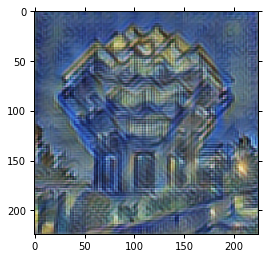

In [80]:
img = generative_model.predict(trainX3)
print trainX3.shape
img = img[0]
imgA = img.swapaxes(0, 2).swapaxes(0, 1)
plt.imshow(imgA)
plt.show()

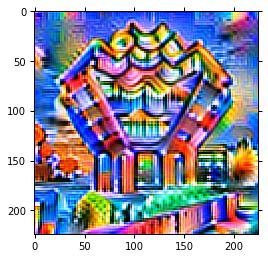

In [33]:
img = generative_model.predict(np.reshape(np.random.rand(3*224*224), (1, -1)))
img = img[0]
imgB = img.swapaxes(0, 2).swapaxes(0, 1)
plt.imshow(imgB)
plt.show()

In [69]:
np.linalg.norm(imgB-imgA)/np.product(imgA.shape)*256

0.029389352214579681

In [65]:
vgg_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_14 (InputLayer)            (None, 3, None, None) 0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 64, None, None 1792        input_14[0][0]                   
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 64, None, None 36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 64, None, None 0           block1_conv2[0][0]               
___________________________________________________________________________________________